In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

In [13]:
want_NN = True # want NN or BDT model?
want_multiclass = True # want multiclass classification or binary?
want_3class = True # want 3 class classification? (Higgs vs ztt vs fakes)
want_iso = False # do you want to include the iso variables?
want_aco_and_others = False # do you want to include the other CP sensitive variables?

In [14]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'

In [15]:
!ls -l /vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/

total 12466911
-rw-r--r-- 1 dw515 cms0 6854308226 Mar  1 10:33 fakes.root
-rw-r--r-- 1 dw515 cms0 2243882311 Mar  1 10:30 ggH.root
-rw-r--r-- 1 dw515 cms0 3547255399 Mar  1 10:29 VBFH.root
-rw-r--r-- 1 dw515 cms0  120669646 Mar  1 10:32 ZTT.root


In [16]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [17]:
vbfh_tree.keys()

[b'genM',
 b'genpT',
 b'gen_nu_p_1',
 b'gen_nu_p_2',
 b'gen_nu_phi_1',
 b'gen_nu_phi_2',
 b'gen_nu_eta_1',
 b'gen_nu_eta_2',
 b'gen_vis_p_1',
 b'gen_vis_p_2',
 b'gen_vis_E_1',
 b'gen_vis_E_2',
 b'gen_vis_phi_1',
 b'gen_vis_phi_2',
 b'gen_vis_eta_1',
 b'gen_vis_eta_2',
 b'pt_2',
 b'pt_1',
 b'iso_1',
 b'met',
 b'wt_cp_sm',
 b'wt_cp_ps',
 b'wt_cp_mm',
 b'mva_dm_1',
 b'mva_dm_2',
 b'tau_decay_mode_2',
 b'tau_decay_mode_1',
 b'trg_singleelectron',
 b'trg_singlemuon',
 b'trg_doubletau',
 b'deepTauVsJets_medium_1',
 b'deepTauVsJets_medium_2',
 b'deepTauVsEle_vvloose_1',
 b'deepTauVsEle_vvloose_2',
 b'deepTauVsEle_tight_1',
 b'deepTauVsEle_tight_2',
 b'deepTauVsMu_vloose_1',
 b'deepTauVsMu_vloose_2',
 b'deepTauVsMu_tight_1',
 b'deepTauVsMu_tight_2',
 b'aco_angle_1',
 b'aco_angle_2',
 b'aco_angle_3',
 b'aco_angle_4',
 b'aco_angle_5',
 b'aco_angle_6',
 b'aco_angle_7',
 b'pv_angle',
 b'mass0',
 b'mass1',
 b'mass2',
 b'ip_sig_1',
 b'ip_sig_2',
 b'rand',
 b'tauFlag_1',
 b'tauFlag_2',
 b'gen_phitt',

In [18]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [19]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [20]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [21]:
vbfh_sm = vbfh[(vbfh["rand"] < vbfh["wt_cp_sm"]/2)]
ggh_sm = ggh[(ggh["rand"] < ggh["wt_cp_sm"]/2)]

In [22]:
vbfh_sm.loc[:, 'y'] = np.zeros(vbfh_sm.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)
ggh_sm.loc[:, 'y'] = np.full((ggh_sm.shape[0],),3.)

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [26]:
scaling = {
    'ggh': 0.0022034,
    'vbfh': 0.0001486,
    'fakes': 1.35,
    'ztt': 3.6292,
}

In [27]:
vbfh.loc[:, 'w'] = vbfh.wt*vbfh.wt_cp_sm *scaling['vbfh']
ztt.loc[:, 'w'] = ztt.wt *scaling['ztt']
fakes.loc[:, 'w'] = fakes.wt *scaling['fakes']
ggh.loc[:, 'w'] = ggh.wt*ggh.wt_cp_sm *scaling['ggh']

In [28]:
higgs = pd.concat([vbfh, ggh]).reset_index(drop=True)

In [29]:
higgs.loc[:, 'y'] = np.zeros(higgs.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)

In [30]:
higgs.loc[:, 'cn'] = np.full((higgs.shape[0],),928.278)
ztt.loc[:, 'cn'] = np.full((ztt.shape[0],),4.716)
fakes.loc[:, 'cn'] = np.full((fakes.shape[0],),1.278)

In [31]:
#vbfh_sm = vbfh_sm[(vbfh_sm != -9999).all(1)]
#ztt = ztt[(ztt != -9999).all(1)]
#fakes = fakes[(fakes != -9999).all(1)]
#ggh_sm = ggh_sm[(ggh_sm != -9999).all(1)]

In [32]:
#ggh_sm.wt.describe()

In [33]:
#df = pd.concat([vbfh_sm, ztt, fakes, ggh_sm]).reset_index(drop=True)
df = pd.concat([higgs, ztt, fakes]).reset_index(drop=True)

In [34]:
#df = df[(df >= 0).all(1)]
df = df[df.wt > 0]

In [202]:
print(sorted(Counter(df.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [203]:
df.head()

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,...,iso_2,wt,rand,wt_cp_sm,deepTauVsJets_medium_1,deepTauVsJets_medium_2,trg_doubletau,os,w,y
0,147.350036,103.916521,83.656017,124.195709,3670.584608,357.812110,370.803543,134.242493,3,237.243256,...,0.956462,0.907956,0.564382,0.365438,True,True,True,True,0.000049,0.0
1,45.724323,41.521388,55.113260,121.425270,180.883915,174.227469,215.791560,151.278168,1,70.621449,...,0.998022,0.734125,0.239110,0.790528,True,True,True,True,0.000086,0.0
2,60.657018,59.239621,60.806931,102.100018,277.772166,299.959394,250.159880,142.520782,3,116.115447,...,0.991346,1.004383,0.403895,1.494004,True,True,True,True,0.000223,0.0
3,78.688465,75.486757,94.940505,99.721180,703.192358,210.365066,72.724995,55.960537,3,128.337830,...,0.901483,1.147851,0.681770,1.703910,True,True,True,True,0.000291,0.0
4,53.302847,52.690613,95.609095,125.425800,-9999.000000,59.758782,66.108686,41.270229,1,51.847839,...,0.993488,0.608865,0.343218,0.046383,True,True,True,True,0.000004,0.0


In [204]:
vbfh_sm.shape[0] + ztt.shape[0] + fakes.shape[0] + ggh_sm.shape[0]

748483

In [205]:
df.describe()

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,iso_1,iso_2,wt,rand,wt_cp_sm,w,y
count,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06,1.397054e+06
mean,7.902178e+01,5.319491e+01,9.728774e+01,1.213277e+02,-2.030094e+03,-8.010304e+02,1.111996e+02,4.160113e+01,1.557367e+00,8.672128e+01,9.717860e-01,9.695296e-01,8.994287e-01,4.998023e-01,8.787751e-01,1.244974e-01,1.683178e-01
std,3.994177e+01,1.558452e+01,2.878330e+01,3.481120e+01,4.668485e+03,2.909333e+03,9.521568e+01,3.819503e+01,1.160000e+00,7.069937e+01,2.895883e-02,2.960651e-02,3.219602e-01,2.885819e-01,6.007535e-01,4.051053e-01,5.332308e-01
min,4.000936e+01,4.000002e+01,2.224759e+01,-2.000000e+00,-9.999000e+03,-9.999000e+03,2.062006e-02,8.978626e-03,0.000000e+00,3.845122e-02,8.834769e-01,8.834769e-01,1.390533e-03,5.704351e-08,0.000000e+00,9.968948e-11,0.000000e+00
25%,5.434698e+01,4.351097e+01,8.429479e+01,1.068228e+02,-9.999000e+03,3.517799e+01,3.379875e+01,1.763792e+01,1.000000e+00,2.749042e+01,9.580358e-01,9.540864e-01,7.857749e-01,2.500552e-01,3.413991e-01,9.715677e-05,0.000000e+00
50%,6.576962e+01,4.811283e+01,9.590882e+01,1.171945e+02,2.188872e+02,8.448784e+01,8.709892e+01,3.048241e+01,2.000000e+00,7.493813e+01,9.830784e-01,9.805500e-01,9.459092e-01,4.994408e-01,9.185191e-01,2.158001e-04,0.000000e+00
75%,8.896601e+01,5.663273e+01,1.062973e+02,1.283460e+02,7.042089e+02,1.529669e+02,1.624603e+02,5.181682e+01,2.000000e+00,1.243027e+02,9.941716e-01,9.930111e-01,1.063098e+00,7.495399e-01,1.364828e+00,1.767259e-03,0.000000e+00
max,8.858887e+02,6.823030e+02,1.986198e+03,3.021397e+03,8.654278e+03,2.946318e+03,2.748502e+03,2.314932e+03,1.100000e+01,9.221425e+02,9.999840e-01,9.999449e-01,3.948676e+01,9.999979e-01,2.000000e+00,2.228313e+01,2.000000e+00


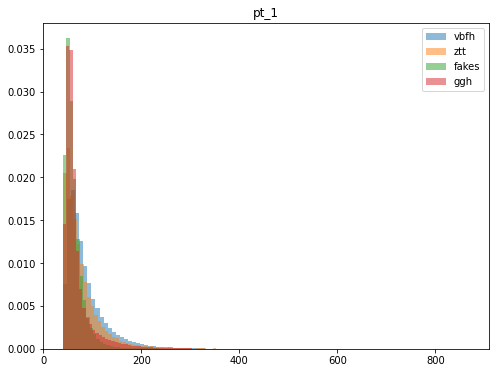

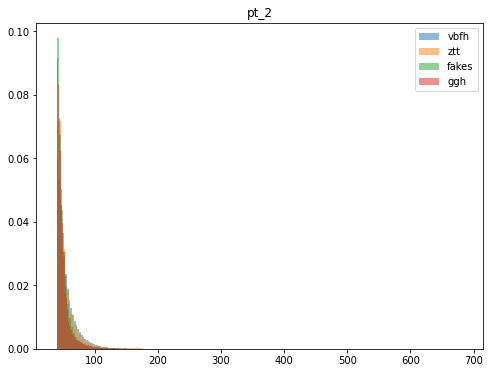

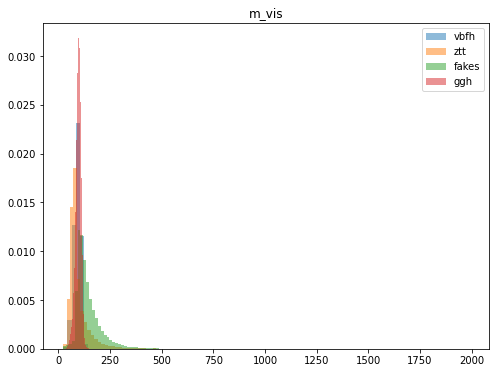

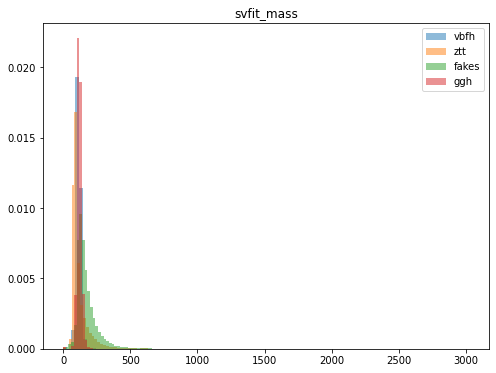

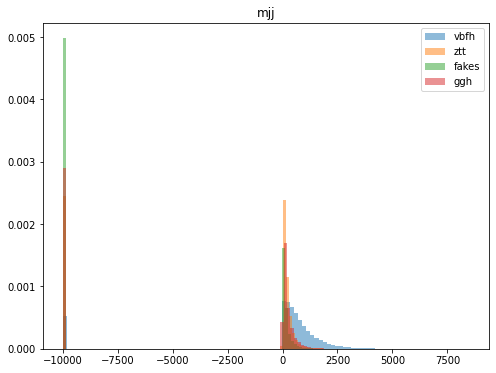

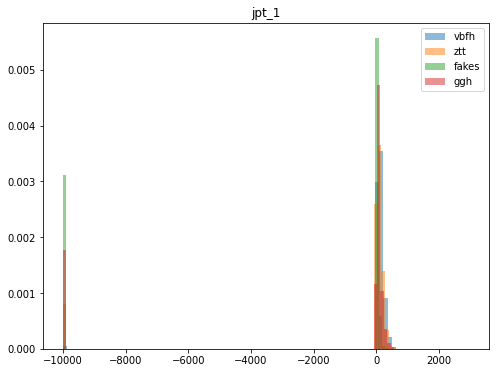

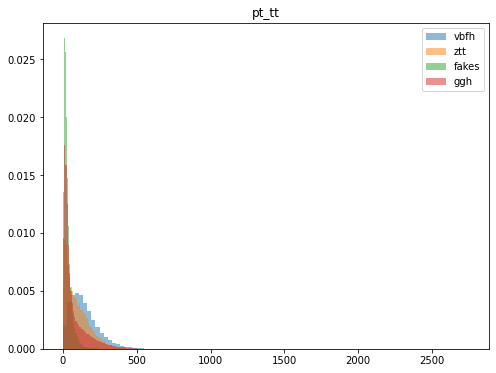

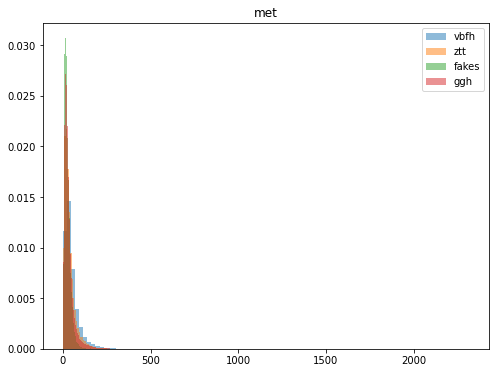

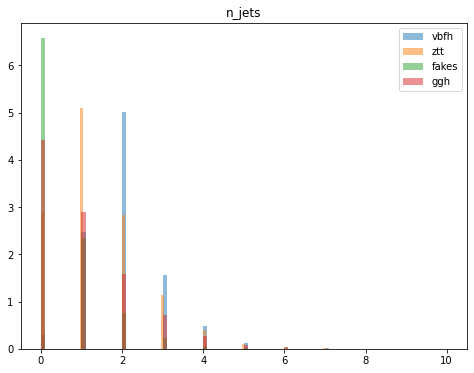

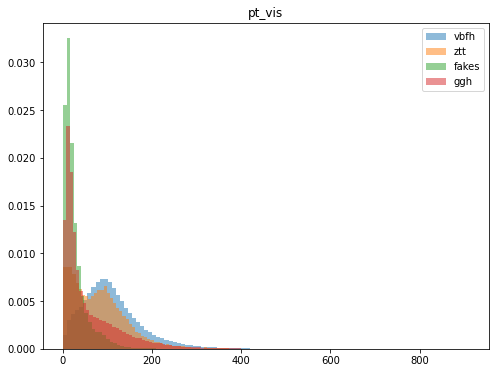

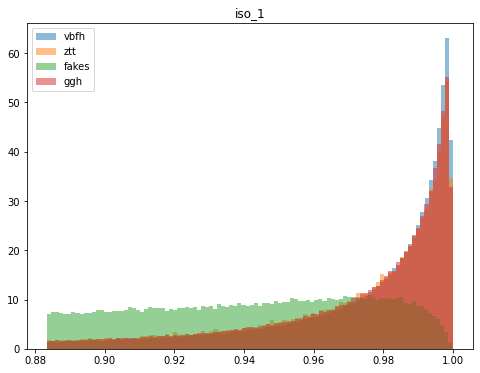

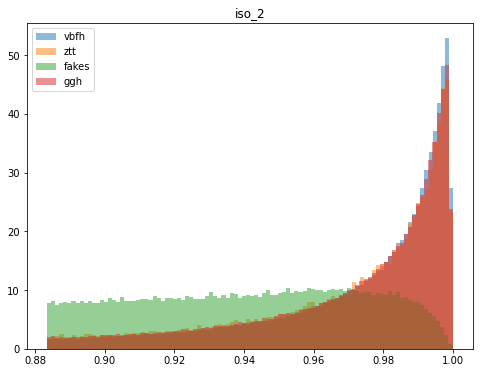

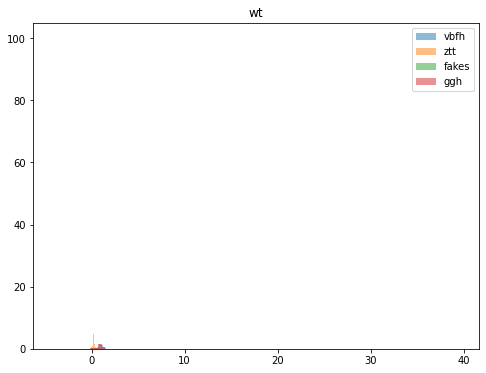

In [206]:
for var in variables:
    fig = plt.figure(figsize=(8,6))
    plt.hist(vbfh_sm[var], bins=100, alpha=0.5, density=True, label='vbfh')
    plt.hist(ztt[var], bins=100, alpha=0.5, density=True, label='ztt')
    plt.hist(fakes[var], bins=100, alpha=0.5, density=True, label='fakes')
    plt.hist(ggh_sm[var], bins=100, alpha=0.5, density=True, label='ggh')
    plt.title(var)
    plt.legend()
    #plt.savefig(f'./signal_background/eda/{var}.png')
plt.show()

In [207]:
!pip install seaborn

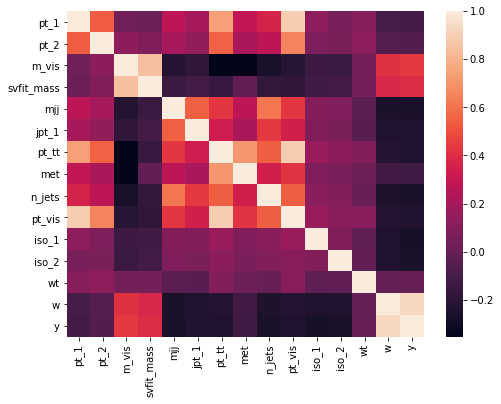

In [208]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(selectors, axis=1).corr())
plt.show()

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


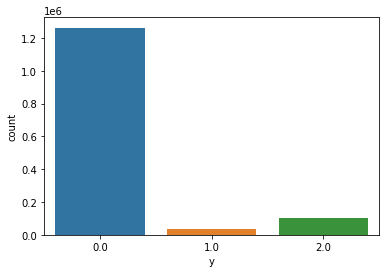

In [209]:
sns.countplot(df['y'])
#plt.savefig('./signal_background/eda/class_count.png')
plt.show()

In [210]:
if not want_iso:
    df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1) # without the iso variables
else:
    df_1 = df.drop(selectors, axis=1) # with the iso variables

In [211]:
X = df_1.drop(['y', 'wt'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.wt
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=123456, stratify=df_1.y)

In [212]:
if not want_multiclass:
    y_train[y_train==3] = 0
    y_test[y_test==3] = 0
    y_train[y_train==2] = 1
    y_test[y_test==2] = 1

In [213]:
!pip install imbalanced-learn

In [214]:
#from imblearn.combine import SMOTEENN, SMOTETomek
#if not want_multiclass:
#    smote_enn = SMOTEENN(random_state=0)
#    X_train, y_train = smote_enn.fit_resample(X_train, y_train)

    #smote_tomek = SMOTETomek(random_state=0)
    #X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

In [215]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))
print(len(y_train))

1010189
26789
1117643


In [216]:
print(np.isnan(X_train).any())
print(np.isnan(y_train).any())

False
False


In [218]:
if want_multiclass and want_NN:
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

In [219]:
if not want_NN: # if want BDT
    # xgb_params = {
    #     "objective": "multi:softmax",
    #     "max_depth": 6,
    #     "num_classes": 4,
    # }
    xgb_params = {
        "objective": "multi:softprob",
        "max_depth": 3,
        "learning_rate": 0.05,
        "silent": 1,
        "n_estimators": 100,
        #"n_estimators": 1000,
        "subsample": 0.9,
        "seed": 123451,
    }

    xgb_clf = xgboost.XGBClassifier(**xgb_params)
    # xgb_clf = xgboost.XGBClassifier()

    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=1000, eval_set=eval_set, eval_metric = "mlogloss")
    # xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

In [220]:
if want_NN:
    model = Sequential()
    model.add(Dense(400, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(400, activation='relu'))
    if want_multiclass and not want_3class:
        model.add(Dense(4, activation='softmax'))
    elif want_3class:
        model.add(Dense(3, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')

In [221]:
def convert_labels(arr):
    return np.argmax(arr, axis=1)

In [230]:
if want_NN:
    #epoch_num = 30
    epoch_num = 5
    model.fit(X_train, y_train, epochs=epoch_num, sample_weight=w_train)
    #model.fit(X_train, y_train, epochs=epoch_num)

Epoch 1/5
34927/34927 [==============================] - 87s 2ms/step - loss: 0.2930
Epoch 2/5
34927/34927 [==============================] - 87s 2ms/step - loss: 0.2930
Epoch 3/5
34927/34927 [==============================] - 87s 2ms/step - loss: 0.2930
Epoch 4/5
34927/34927 [==============================] - 87s 2ms/step - loss: 0.2930
Epoch 5/5
34927/34927 [==============================] - 86s 2ms/step - loss: 0.2930


In [231]:
if want_NN:
    y_pred = model.predict(X_test)
else:
    y_pred = xgb_clf.predict(X_test)
if want_multiclass and want_NN:
    y_pred_simple = convert_labels(y_pred)
    y_test_simple = convert_labels(y_test)
    print(accuracy_score(y_test_simple, y_pred_simple))
    if not want_3class:
        names = ['vbfH', 'ztt', 'fakes', 'ggH']
    if want_3class:
        names = ['higgs', 'ztt', 'fakes']
    print(classification_report(y_test_simple, y_pred_simple, target_names=names, sample_weight=w_test))
    #print(classification_report(y_test_simple, y_pred_simple, target_names=names))
else:
    print(accuracy_score(y_test, y_pred))

0.9038548947607646
/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
              precision    recall  f1-score   support

       higgs       0.91      1.00      0.95 229025.98940050972
         ztt       0.00      0.00      0.00 2021.1690680061363
       fakes       0.00      0.00      0.00   20166.0

    accuracy                           0.91 251213.15846851585
   macro avg       0.30      0.33      0.32 251213.15846851585
weighted avg       0.83      0.91      0.87 251213.15846851585

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

In [224]:
if want_NN:
    y_pred_proba = model.predict_proba(X_test)
else:
    y_pred_proba = xgb_clf.predict_proba(X_test)

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [225]:
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
print(roc_auc_score(y_test, y_pred_proba, multi_class='ovo'))


0.5
0.5


In [226]:
if want_multiclass:
    if not want_3class:
        onehot=label_binarize(y_test_simple,classes=[0,1,2,3])
    else:
        onehot = label_binarize(y_test_simple, classes=[0, 1, 2])
    fpr=dict()
    tpr=dict()
    thresh = dict()
    roc_auc=dict()
    if want_3class:
        class_num = 3
    else:
        class_num = 4
    for i in range(class_num):
        fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred_proba[:,i], sample_weight=w_test)#,None,w_test
        #fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred_proba[:,i])#,None,w_test
        roc_auc[i] = auc(fpr[i], tpr[i])#,reorder=True)

In [227]:
print(set(list(y_pred_proba.flatten())))
print(set(y_pred.flatten()))

{0.9116854, 0.007994709, 0.08031991}
{0.9116854, 0.007994709, 0.08031991}


In [228]:
if not want_multiclass:
    fpr, tpr, thresh = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr)

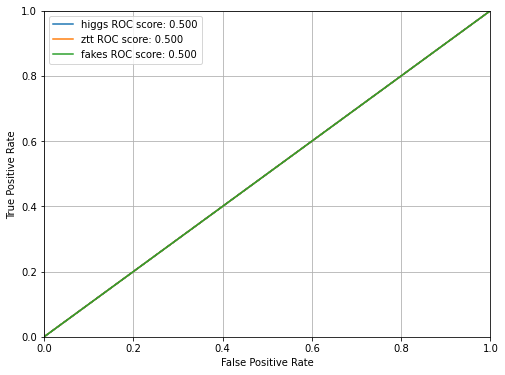

In [229]:
if want_multiclass:
    classes = ['vbfH', 'ztt', 'fakes', 'ggH']
    if want_3class:
        classes = ['higgs', 'ztt', 'fakes']
    fig, ax = plt.subplots(figsize=(8,6))
    def plot_roc_curve(fpr, tpr, auc, i):
        ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
        ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    #     ax.text(0.6, 0.3, 'ROC AUC Score: {:.3f}'.format(auc),
    #             bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='k'))
        plt.legend()
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, 'k--')
    ax.grid()
    for i in range(len(fpr)):
        plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
    # plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
    # plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
    # plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
    #plt.savefig('./signal_background/eda/roc_curves.png')

# with iso variables

In [35]:
df_2 = df.drop(selectors, axis=1)

In [36]:
print(sorted(Counter(df_2.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [37]:
df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [59]:
X = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test= train_test_split(X, y, w, df.cn, test_size=0.3, random_state=123456, stratify=df_2.y)

In [60]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [61]:
model = Sequential()
model.add(Dense(400, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [62]:
epoch_num = 5
model.fit(X_train, y_train, epochs=epoch_num, sample_weight=w_train)

Epoch 1/5
30561/30561 [==============================] - 80s 3ms/step - loss: 0.3067
Epoch 2/5
30561/30561 [==============================] - 80s 3ms/step - loss: 0.0604
Epoch 3/5
30561/30561 [==============================] - 78s 3ms/step - loss: 0.0604
Epoch 4/5
30561/30561 [==============================] - 79s 3ms/step - loss: 0.0592
Epoch 5/5
30561/30561 [==============================] - 79s 3ms/step - loss: 0.0593


In [63]:
y_pred = model.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [64]:
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend()

def convert_labels(arr):
    return np.argmax(arr, axis=1)

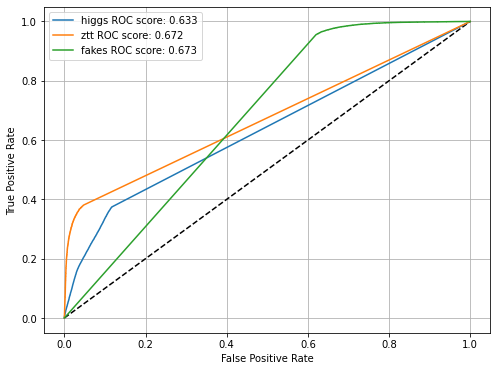

In [65]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

In [66]:
cr = classification_report(convert_labels(y_test), convert_labels(model.predict(X_test)), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.443282,0.002596,0.005162,278.237909
ztt,0.751220,0.354813,0.481979,10967.232884
fakes,0.845175,0.970677,0.903589,40836.150000
accuracy,0.835818,0.835818,0.835818,0.835818
macro avg,0.679892,0.442695,0.463577,52081.620793
weighted avg,0.823243,0.835818,0.810008,52081.620793


In [67]:
y_pred = model.predict_proba(X_test)

/home/hep/kg1416/anaconda3/envs/kristofenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


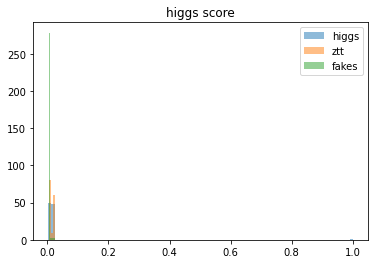

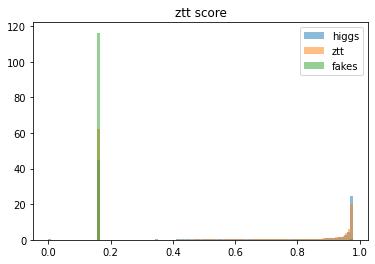

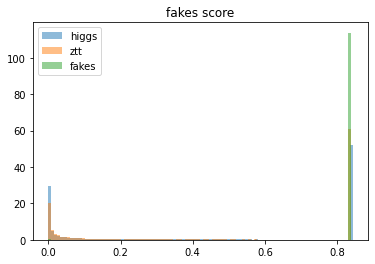

In [68]:
y_test = convert_labels(y_test)
labels = ['higgs', 'ztt', 'fakes']
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 0][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[0]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 1][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[1]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 2][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[2]+' score')
plt.legend()
plt.show()

In [ ]:
def count(dataset, counters=np.zeros(4)):
    for i in range(len(dataset)):
        if 0.0 < dataset[i] and dataset[i] <= 0.7:
            counters[0] += 1
        elif 0.7 < dataset[i] and dataset[i] <= 0.8:
            counters[1] += 1
        elif 0.8 < dataset[i] and dataset[i] <= 0.9:
            counters[2] += 1
        elif 0.9 < dataset[i] and dataset[i] <= 1.0:
            counters[3] += 1
    return counters
S_counters = count(higgs)
ztt_counters = count(ztt)
fakes_counters = count(fakes)
B_counters = count(fakes, ztt_counters)